# Heat decomposition in ECCO

In [1]:
import numpy as np
import xarray as xr
import xgcm
# Suppress warning messages for a cleaner presentation
# import warnings
# warnings.filterwarnings('ignore')

## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library,
##    tell Python where to find it.

import sys
sys.path.append('/home/jovyan/ECCOv4-py/ECCOv4-py')

import ecco_v4_py as ecco

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import cartopy as cart
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.Robinson(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)

        ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.4, label=label)
        return ax

## Connect to Dask Cluster

In [3]:
from dask_gateway import Gateway, GatewayCluster
gateway = Gateway()

In [4]:
gateway.list_clusters()

[]

In [5]:
cluster = gateway.connect(gateway.list_clusters()[0].name)
client = cluster.get_client()

IndexError: list index out of range

In [ ]:
cluster = GatewayCluster()
# cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
cluster.adapt(minimum=2, maximum=50)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [ ]:
gateway

In [ ]:
cluster

In [ ]:
client

## Add relevant constants

In [6]:
base_dir = '/home/jovyan/'

In [7]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

## Load ECCOv4r3 data from catalog

In [8]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds0  = cat["ECCOv4r3"].to_dask()

In [10]:
cat.LLC4320.LLC4320_SSH.to_dask()

,Array,Chunk
Bytes,8.76 TB,74.65 MB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,float32,numpy.ndarray


In [6]:
ds0

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drC        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyG        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC      (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS      (k, face, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW      (k, face, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter_snp   (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    rA         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    ADVr_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, face, j, i) float32 das

In [7]:
#Volume (m^3)
vol = (ds0.rA*ds0.drF*ds0.hFacC).transpose('face','k','j','i')

In [10]:
mapper = LLCMapper(ds0)

# Fast method (since on pangeo all data already like that)

In [12]:
year_start = 1993
year_end = 2015

ds = ds0[['UVELMASS','UVELSTAR','VVELMASS','VVELSTAR','WVELMASS','WVELSTAR','ETAN_snp','THETA_snp',
                        'ETAN','THETA','MXLDEPTH',
                        'TFLUX','oceQsw','ADVx_TH','ADVy_TH','ADVr_TH',
                        'DFxE_TH','DFyE_TH','DFrE_TH','DFrI_TH']].sel(
    time_snp=slice('%i-01-01' % year_start,'%i-01-01' % year_end),time=slice('%i' % year_start,'%i' % (year_end - 1)))

## Create the xgcm 'grid' object

In [12]:
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point

In [13]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [14]:
# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(ds, periodic=False, face_connections=face_connections,metrics=metrics)

## Number of seconds in each month



In [15]:
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# Convert to seconds
delta_t = delta_t.astype('f4') / 1e9

In [17]:
1

1

In [8]:
from dask.diagnostics import ProgressBar

In [21]:
with ProgressBar():
    ds.to_zarr(base_dir + '/eccov4r3_keyvars')

[########################################] | 100% Completed | 13min 17.1s


In [15]:
with ProgressBar():
    ds[['MXLDEPTH']].to_zarr(base_dir + '/MXLDEPTH')

[########################################] | 100% Completed |  1min  5.2s


In [22]:
1

1

# Residual velocities

In [77]:
ds['UVELRES'] = ds['UVELMASS'] + ds['UVELSTAR']
ds['VVELRES'] = ds['VVELMASS'] + ds['VVELSTAR']
ds['WVELRES'] = ds['WVELMASS'] + ds['WVELSTAR']

# Climatological means and anomalies

In [78]:
THETA_c = ds.THETA.groupby('time.month').mean()
UVELRES_c = ds.UVELRES.groupby('time.month').mean()
VVELRES_c = ds.VVELRES.groupby('time.month').mean()
WVELRES_c = ds.WVELRES.groupby('time.month').mean()

THETA_p = ds.THETA.groupby('time.month') - THETA_c
UVELRES_p = ds.UVELRES.groupby('time.month') - UVELRES_c
VVELRES_p = ds.VVELRES.groupby('time.month') - VVELRES_c
WVELRES_p = ds.WVELRES.groupby('time.month') - WVELRES_c

# Compute advection terms

### Tm vm

In [79]:
# horizontal divergences 
circh_Tmvm = \
grid.diff_2d_vector({'X':UVELRES_c * grid.interp(THETA_c,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_c * grid.interp(THETA_c,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [80]:
# vertical convergence
circv_Tmvm = grid.diff(WVELRES_c * grid.interp(THETA_c,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [81]:
# total convergence
circ_Tmvm = - circh_Tmvm['X'] - circh_Tmvm['Y'] + circv_Tmvm

In [82]:
# top 300 m integral
circ_Tmvm_50 = circ_Tmvm.isel(k=slice(5)).sum('k')
circ_Tmvm_300 = circ_Tmvm.isel(k=slice(20)).sum('k')

### Tm vp

In [83]:
# horizontal divergences 
circh_Tmvp = \
grid.diff_2d_vector({'X':UVELRES_c * grid.interp(THETA_p,'X',boundary='fill').groupby('time.month') * ds.dyG * ds.drW,
                     'Y':VVELRES_c * grid.interp(THETA_p,'Y',boundary='fill').groupby('time.month') * ds.dxG * ds.drS},boundary='fill')

In [84]:
# vertical convergence
circv_Tmvp = grid.diff(WVELRES_c * grid.interp(THETA_p,'Z',boundary='fill').groupby('time.month') * ds.rA,'Z',boundary='fill')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/

In [85]:
# total convergence
circ_Tmvp = - circh_Tmvp['X'] - circh_Tmvp['Y'] + circv_Tmvp

In [86]:
# top 300 m integral
circ_Tmvp_50 = circ_Tmvp.isel(k=slice(5)).sum('k')
circ_Tmvp_300 = circ_Tmvp.isel(k=slice(20)).sum('k')

### Tp vm

In [87]:
# horizontal divergences 
circh_Tpvm = \
grid.diff_2d_vector({'X':UVELRES_p.groupby('time.month') * grid.interp(THETA_c,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_p.groupby('time.month') * grid.interp(THETA_c,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [88]:
# vertical convergence
circv_Tpvm = grid.diff(WVELRES_p.groupby('time.month') * grid.interp(THETA_c,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [89]:
# total convergence
circ_Tpvm = - circh_Tpvm['X'] - circh_Tpvm['Y'] + circv_Tpvm

In [90]:
# top 300 m integral
circ_Tpvm_50 = circ_Tpvm.isel(k=slice(5)).sum('k')
circ_Tpvm_300 = circ_Tpvm.isel(k=slice(20)).sum('k')

### Tp vp

In [91]:
# horizontal divergences 
circh_Tpvp = \
grid.diff_2d_vector({'X':UVELRES_p * grid.interp(THETA_p,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_p * grid.interp(THETA_p,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [92]:
# vertical convergence
circv_Tpvp = grid.diff(WVELRES_p * grid.interp(THETA_p,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [93]:
# total convergence
circ_Tpvp = - circh_Tpvp['X'] - circh_Tpvp['Y'] + circv_Tpvp

In [94]:
# top 300 m integral
circ_Tpvp_50  = circ_Tpvp.isel(k=slice(5)).sum('k')
circ_Tpvp_300 = circ_Tpvp.isel(k=slice(20)).sum('k')

## Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)

### Horizontal convergence of diffusive heat flux

In [95]:
DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')
# Convergence of horizontal diffusion (degC m^3/s)
dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

### Vertical convergence of diffusive heat flux

In [96]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds.DFrE_TH.transpose('time','face','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time','face','k_l','j','i')
# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='fill') + grid.diff(DFrI_TH, 'Z', boundary='fill')

### Total convergence of diffusive flux ($G^{\theta}_\textrm{diffusion}$)

In [97]:
# Sum horizontal and vertical convergences and divide by volume (degC.m^3/s)
G_diffusion = dif_hConvH + dif_vConvH

### Mean and anomaly

In [98]:
G_diffusion_c = G_diffusion.groupby('time.month').mean()
G_diffusion_p = G_diffusion.groupby('time.month') - G_diffusion_c

In [99]:
G_diffusion_c_50  = G_diffusion_c.isel(k=slice(5)).sum('k')
G_diffusion_c_300 = G_diffusion_c.isel(k=slice(20)).sum('k')

In [ ]:
G_diffusion_p_50  = G_diffusion_p.isel(k=slice(5)).sum('k')
G_diffusion_p_300 = G_diffusion_p.isel(k=slice(20)).sum('k')

### Mean and anomaly, method 2

In [ ]:
G_diffusion_50  = G_diffusion.isel(k=slice(5)).sum('k')
G_diffusion_300 = G_diffusion.isel(k=slice(20)).sum('k')

In [ ]:
G_diffusion_50_c = G_diffusion_50.groupby('time.month').mean()
G_diffusion_50_p = G_diffusion_50.groupby('time.month') - G_diffusion_50_c
G_diffusion_300_c = G_diffusion_300.groupby('time.month').mean()
G_diffusion_300_p = G_diffusion_300.groupby('time.month') - G_diffusion_300_c

### test dask queue

# Loading and saving

In [ ]:
circ_Tmvm_50.load()
circ_Tmvm_300.load()
circ_Tmvm_50.to_netcdf('circ_Tmvm_50.nc')
circ_Tmvm_300.to_netcdf('circ_Tmvm_300.nc')

In [100]:
circ_Tmvp_50.load()

KeyboardInterrupt: 

In [ ]:
1

In [ ]:
circ_Tmvp_300.load()

In [ ]:
circ_Tmvp_50.to_netcdf('circ_Tmvp_50.nc')
circ_Tmvp_300.to_netcdf('circ_Tmvp_300.nc')

In [ ]:
circ_Tpvp_50.load()
circ_Tpvp_300.load()

circ_Tpvp_50.to_netcdf('circ_Tpvp_50.nc')
circ_Tpvp_300.to_netcdf('circ_Tpvp_300.nc')

In [ ]:
G_diffusion_c_50.load()

In [ ]:
G_diffusion_c_300.load()

In [ ]:
G_diffusion_c_50.to_netcdf('G_diffusion_c_50.nc')
G_diffusion_c_300.to_netcdf('G_diffusion_c_300.nc')

# Testing code

In [98]:
test_u = ds.UVELRES.isel(time=100,k=slice(5)) * grid.interp(ds.THETA.isel(time=100,k=slice(5)),'X',boundary='fill') * ds.dyG * ds.drW.isel(k=slice(5))
test_v = ds.VVELRES.isel(time=100,k=slice(5)) * grid.interp(ds.THETA.isel(time=100,k=slice(5)),'Y',boundary='fill') * ds.dxG * ds.drS.isel(k=slice(5))
test_u.load()
test_v.load()

In [134]:
test_uv = grid.diff_2d_vector({'X':test_u,'Y':test_v},boundary='fill')
test_uv = -test_uv['X'] - test_uv['Y']

(<Figure size 648x568.08 with 17 Axes>,
 array([[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ...,  0.,  0.,  0.],
        [-0., -0., -0., ...,  0.,  0.,  0.],
        [-0., -0., -0., ...,  0.,  0.,  0.]]))

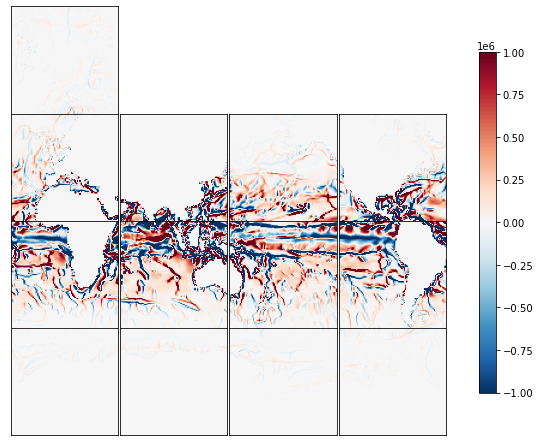

In [139]:
ecco.plot_tiles(test_uv.isel(k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
                cmax=1e6,cmin=-1e6
               )

(<Figure size 648x568.08 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

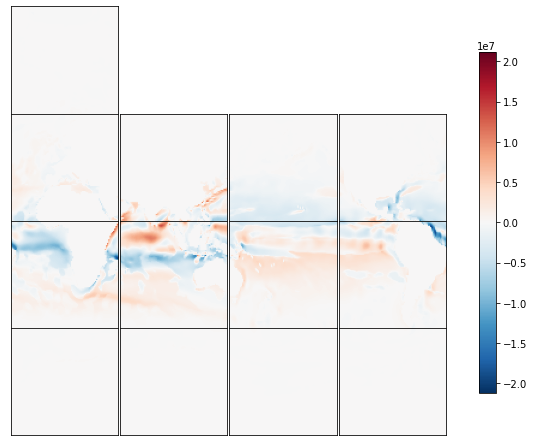

In [101]:
ecco.plot_tiles(test_u.isel(k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
#                 cmax=3e10,cmin=-3e10
               )

(<Figure size 648x568.08 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

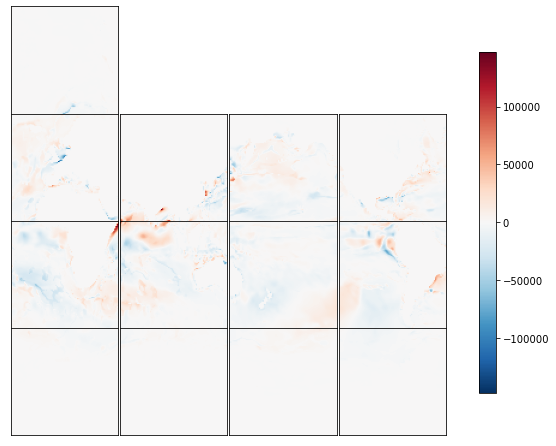

In [108]:
ecco.plot_tiles(test_u.isel(k=0).rename({'face':'tile'}) - ds.ADVx_TH.isel(time=100,k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
#                 cmax=2e5,cmin=-2e5
               )

(<Figure size 648x568.08 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

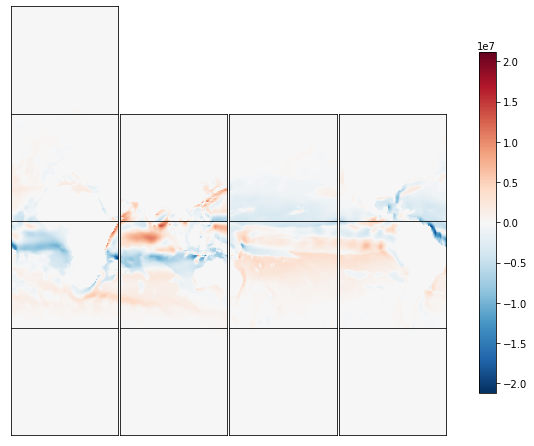

In [104]:
ecco.plot_tiles(ds.ADVx_TH.isel(time=100,k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
#                 cmax=3e10,cmin=-3e10
               )